<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [1]:
%%bash
pip install --no-cache-dir -qU \
    tensorflow tensorflow-probability tf_keras

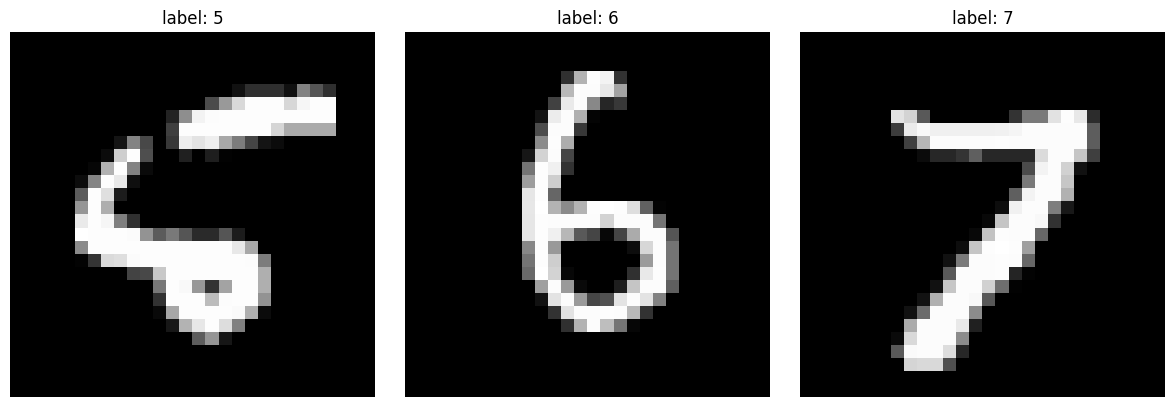

(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [1]:
import tensorflow as tf
tf.random.set_seed(seed=42)
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
fig, axes =  plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for ax, x, y in zip(axes, x_plt, y_plt):
    ax.set_title(label=f"label: {y}")
    ax.imshow(X=x, cmap="gray")
    ax.axis("off")
fig.tight_layout()
plt.show()

class PreprocessingModule(tf.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.preprocess = tf.keras.Sequential(layers=[
            tf.keras.layers.Rescaling(scale=1./255),
            tf.keras.layers.Reshape(target_shape=(784,))
        ])

    @tf.function
    def __call__(self, x):
        return self.preprocess(inputs=x)
preprocessing_model = PreprocessingModule(name="preprocessing")

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=32)
    ds = ds.map(map_func=lambda x, y: (preprocessing_model(x=x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

Training duration: 65s
Test loss: 0.0921, Test acc: 0.9759


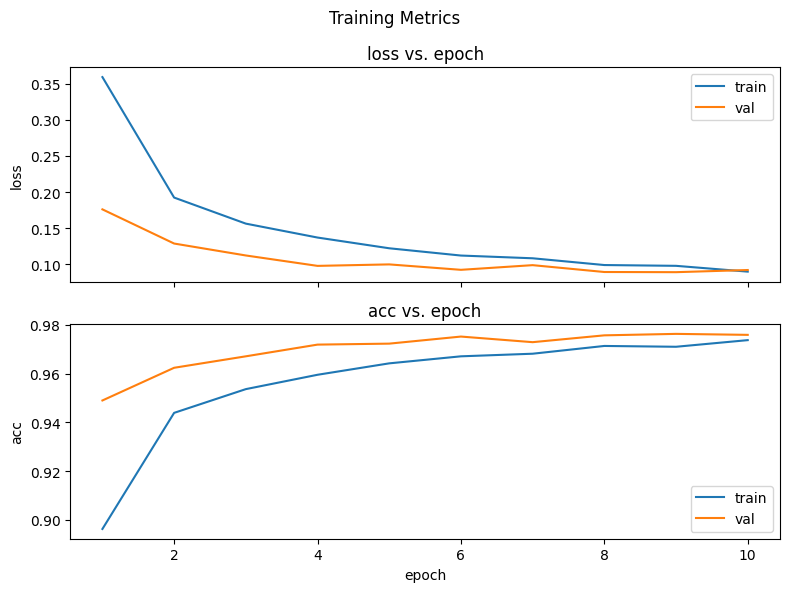

In [2]:
import os
import tf_keras
import tensorflow as tf
tf.random.set_seed(seed=42)
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

@tf_keras.saving.register_keras_serializable()
class TrainingModel(tf.keras.Model):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.dnn = tf.keras.Sequential(layers=[
            tf.keras.Input(shape=input_shape, dtype=tf.float32),
            tf.keras.layers.Dense(units=64,
                activation=tf.keras.activations.relu,
                kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5)),
            tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Dense(units=10,
                activation=tf.keras.activations.softmax)
        ])

    def call(self, inputs, training=False):
        return self.dnn(inputs=inputs, training=training)

    @tf.function
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(inputs=x, training=True)
            loss = self.compute_loss(y=y, y_pred=y_pred)
        vars = self.trainable_variables
        grads = tape.gradient(target=loss, sources=vars)
        self.optimizer.apply_gradients(grads_and_vars=zip(grads, vars))
        for m in self.metrics:
            if m.name=="loss":
                m.update_state(values=loss)
            else:
                m.update_state(y_true=y, y_pred=y_pred)
        return {m.name: m.result() for m in self.metrics}

training_model = TrainingModel(input_shape=(784,), name="training")
training_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

start_time = time.time()
os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
history = training_model.fit(x=ds_train, validation_data=ds_test,
    epochs=10, verbose=0,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
            mode="min", patience=1, factor=0.9),
        tf.keras.callbacks.ModelCheckpoint(monitor="val_acc",
            mode="max", save_best_only=True, save_weights_only=True,
            filepath=ckptPath)
])
print("Training duration: %2.fs"%(time.time() - start_time))
loss, acc = training_model.evaluate(x=ds_test, verbose=0)
print(f"Test loss: %.4f, Test acc: %.4f"%(loss, acc))

df_history = pd.DataFrame(history.history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))
axes[1].set_xlabel(xlabel="epoch")
fig.suptitle(t="Training Metrics")
for ax, m in zip(axes, ["loss", "acc"]):
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=m)
    sns.lineplot(ax=ax, label="val", data=df_history,
        x="epoch", y=f"val_{m}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=m)
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

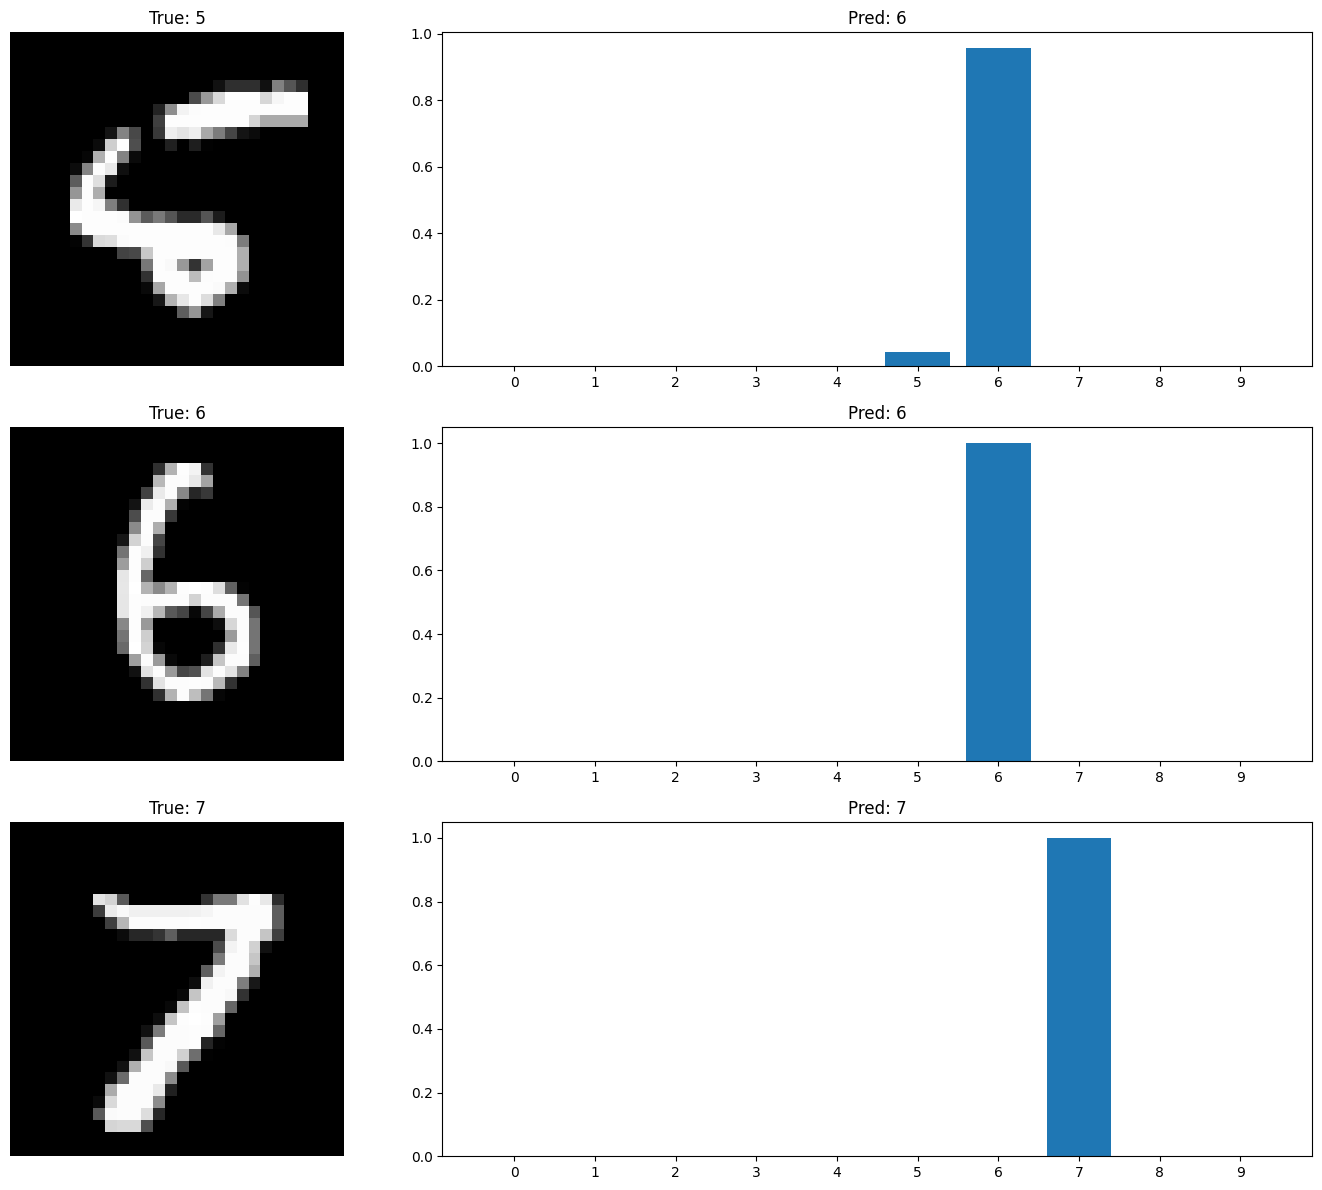

In [ ]:
import tensorflow as tf
tf.random.set_seed(seed=42)
import numpy as np
import matplotlib.pyplot as plt

training_model.load_weights(ckptPath)
x = preprocessing_model.input
y = training_model(inputs=preprocessing_model(inputs=x))
inference_model = tf.keras.Model(inputs=x, outputs=y)

x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
probs = inference_model.predict(x=x_plt, verbose=0)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)
for ax, x, y, prob in zip(axes, x_plt, y_plt, probs):
    ax[0].set_title(label=f"True: {y}")
    ax[0].imshow(X=x, cmap="gray")
    ax[0].axis("off")
    ax[1].set_title(label=f"Pred: {tf.math.argmax(input=prob)}")
    ax[1].bar(x=np.arange(len(prob)), height=prob)
    ax[1].set_xticks(ticks=np.arange(len(prob)))
fig.tight_layout()
plt.show()